In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
zero = 0
a = 10
num_points = 500
num_iter = 5000

In [3]:
#boundary conditions
def psi_bc(x):
  return 0*x
#PDE d^2Ψ/dt^2 + k^2Ψ = 0 output tending to zero
def schrodinger(x):
  return 1e-10*x

In [4]:
class PINN(nn.Module):
    def __init__(self, num_layers, input_size, hidden_size, output_size):
        super().__init__()
        self.activation = nn.GELU()
        self.num_layers = num_layers
        self.layers = nn.ModuleList([nn.Linear(input_size, hidden_size)])
        self.layers.extend([nn.Linear(hidden_size, hidden_size) for i in range(num_layers)])
        self.layers.append(nn.Linear(hidden_size, output_size))

    def forward(self,x):
        for i in range(self.num_layers):  
            x = self.layers[i](x)              
            x = self.activation(x)    
        x = self.layers[-1](x)
        return x

    def loss_pinn(self, x, x_bc):
        #define boundary conditions loss
        bc_loss = nn.MSELoss()(self.forward(x_bc), psi_bc(x_bc))
        
        #define PDE loss
        psi_in = x.clone()
        psi_in.requires_grad=True
        psi_out = self.forward(psi_in)
        psi_x = torch.autograd.grad(psi_out, psi_in, torch.ones([x.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        psi_xx = torch.autograd.grad(psi_x, psi_in, torch.ones([x.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        f = psi_xx + psi_out
        pde_loss = nn.MSELoss()(f, schrodinger(psi_in))
      
        return bc_loss + pde_loss

In [5]:
x = torch.linspace(zero, a, num_points).view(-1,1)
bc_1 = x[0, :]
bc_2 = x[-1, :]
bc_input = torch.vstack([bc_1, bc_2])
pde_input = (bc_2-bc_1)*np.random.rand(250,1)
pde_input = pde_input.float().to(device)
bc_input = bc_input.float().to(device)

In [6]:
model = PINN(num_layers = 5, input_size = 1, hidden_size = 64, output_size = 1)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,amsgrad=False)

Step:  0
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)


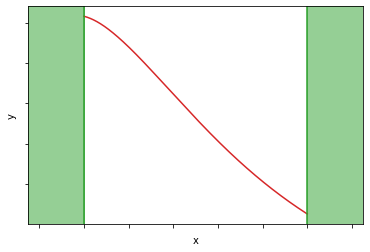

Step:  500
tensor(3.9468e-10, device='cuda:0', grad_fn=<AddBackward0>)


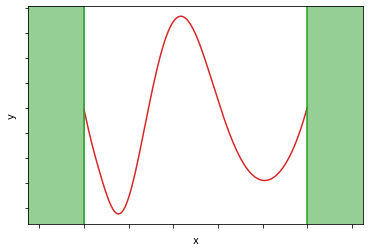

Step:  1000
tensor(1.3777e-10, device='cuda:0', grad_fn=<AddBackward0>)


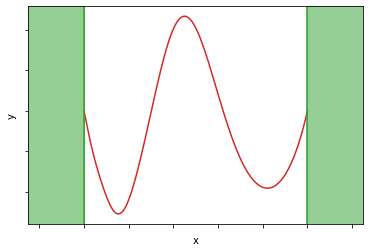

Step:  1500
tensor(9.2241e-11, device='cuda:0', grad_fn=<AddBackward0>)


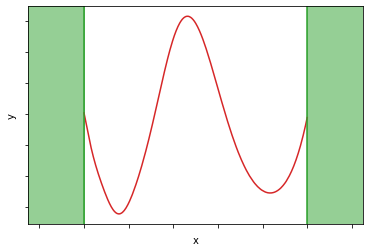

Step:  2000
tensor(7.3808e-11, device='cuda:0', grad_fn=<AddBackward0>)


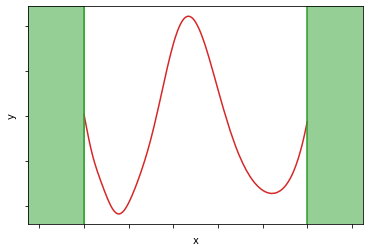

Step:  2500
tensor(6.0183e-11, device='cuda:0', grad_fn=<AddBackward0>)


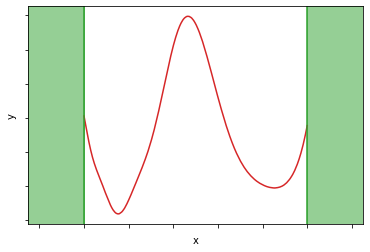

Step:  3000
tensor(4.9052e-11, device='cuda:0', grad_fn=<AddBackward0>)


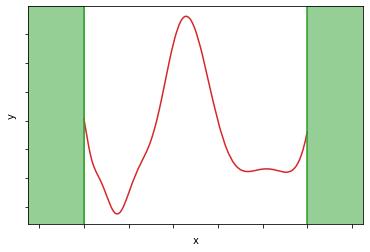

Step:  3500
tensor(1.5046e-08, device='cuda:0', grad_fn=<AddBackward0>)


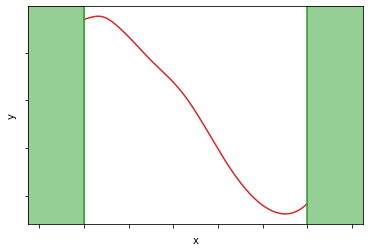

Step:  4000
tensor(1.9259e-08, device='cuda:0', grad_fn=<AddBackward0>)


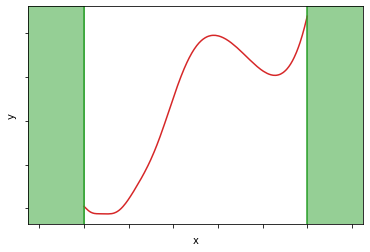

Step:  4500
tensor(1.0906e-07, device='cuda:0', grad_fn=<AddBackward0>)


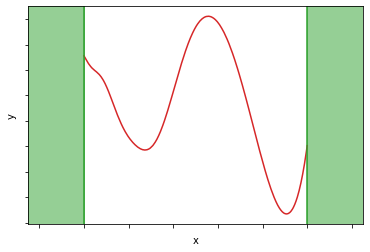

In [7]:
for i in range(5000):
    model.train()
    y_hat = model(pde_input)
    loss = model.loss_pinn(pde_input,bc_input)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i%(5000/10) == 0:
        print('Step: ', i)
        print(loss)

        yh = model(x.to(device))
        yh_plot = yh.detach().cpu().numpy()

        fig, ax1 = plt.subplots()
        ax1.plot(x, yh_plot, color='tab:red', label='Prediction')
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        plt.xlim(-2.5, 12.5)
        plt.axvline(0.0, color='tab:green')
        plt.axvline(10.0, color='tab:green')
        plt.axvspan(-2.5, 0, alpha=0.5, color='tab:green')
        plt.axvspan(10., 12.5, alpha=0.5, color='tab:green')
        ax1.set_yticklabels([])
        ax1.set_xticklabels([])
        # plt.savefig("se_"+str(i)+".pdf", bbox_inches='tight')
        plt.show()